In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import h5py
import seaborn as sns

test_size = 0.20
N = int(2500 * test_size)
fid = h5py.File(r"/Users/nathanbrockbank/Downloads/Project_Packet/dataset_patchcamelyon.h5", 'r') 
X_test, Y_test = fid['X'][:N], fid['Y'][:N]
X, Y = fid['X'][N:], fid['Y'][N:]
X = X / 255.
X_test = X_test / 255.
fid.close()

print(X.shape, X_test.shape, Y.shape, Y_test.shape)



(2000, 96, 96, 3) (500, 96, 96, 3) (2000, 1, 1, 1) (500, 1, 1, 1)


In [2]:
X_gs = tf.image.rgb_to_grayscale(X)
X_gs_test = tf.image.rgb_to_grayscale(X_test)

print(X_gs.shape, X_gs_test.shape)

(2000, 96, 96, 1) (500, 96, 96, 1)


In [3]:
Y = np.asarray([[y] for y in Y.reshape(len(Y))])
Y_test = np.asarray([[y] for y in Y_test.reshape(len(Y_test))])

print(Y.shape, X.shape)


(2000, 1) (2000, 96, 96, 3)


In [39]:
def create_cnn(color=True, dense_units=[32, 16], conv1x1=False, bn=True, dr=0.3, 
               pool_fcn='max', opt_fcn='SGD', lr = 0.01, act_fcn='selu', 
               filters_t=[16, 32, 64], kernels=[6, 3], stride=2, pad_mthd='same'):
    
    # determine input (RBG/GS)
    if color:
        input_shape = [96, 96, 3]
    else:
        input_shape = [96, 96, 1]
    
    # ensure there are filter and kernel sizes set for each convolutional layer
    filters = [f for f in filters_t]
    kernel_size = [k for k in kernels]
    if type(dense_units) == int:
        d_units = [dense_units]
    else:
        d_units = [d for d in dense_units]
    
    c_depth = max(len(filters), len(kernel_size))
    if len(filters)>len(kernel_size):
        while len(filters)>len(kernel_size):
            kernel_size.append(kernel_size[len(kernel_size)-1])
    elif len(filters)<len(kernel_size):
        while len(filters)<len(kernel_size):
            filters.append(filters[len(filters)-1])
    
    # create cnn
    cnn_clf = keras.models.Sequential()
    
    # add convolutional layers
    if pool_fcn == "max":
        for i in range(c_depth):
            cnn_clf.add(keras.layers.Conv2D(filters=filters[i], kernel_size=kernel_size[i], activation=act_fcn, padding=pad_mthd, input_shape=input_shape))
            cnn_clf.add(keras.layers.MaxPooling2D(2))
    elif pool_fcn == "average":
        for i in range(c_depth):
            cnn_clf.add(keras.layers.Conv2D(filters=filters[i], kernel_size=kernel_size[i], activation=act_fcn, padding=pad_mthd, input_shape=input_shape))
            cnn_clf.add(keras.layers.AveragePooling2D(2))
    
    # 1x1 convolutional layer
    if conv1x1:
        cnn_clf.add(keras.layers.Conv2D(filters=filters[len(filters)-1], kernel_size=1))
    else:
        pass
    
    cnn_clf.add(keras.layers.Flatten())
    
    # add dense layers
    if bn:
        for i in d_units:
            cnn_clf.add(keras.layers.BatchNormalization())
            cnn_clf.add(keras.layers.Dense(i, activation=act_fcn, kernel_initializer='lecun_normal'))
            cnn_clf.add(keras.layers.Dropout(dr))
    else:
        for i in d_units:
            cnn_clf.add(keras.layers.Dense(i, activation=act_fcn, kernel_initializer='lecun_normal'))
            cnn_clf.add(keras.layers.Dropout(dr))

    # define optimizer fcn
    if opt_fcn == 'Adam':
        opt = keras.optimizers.Adam(lr=lr)
    elif opt_fcn == 'SGD':
        opt = keras.optimizers.SGD(lr=lr, nesterov=True)
    elif opt_fcn == 'RMSprop':
        opt = keras.optimizers.RMSprop(lr=lr)
    
    # add output layer and compile
    cnn_clf.add(keras.layers.Dense(1, activation='sigmoid'))
    cnn_clf.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return cnn_clf

cnn_wrap = keras.wrappers.scikit_learn.KerasClassifier(create_cnn)

cp_cb_cnn = keras.callbacks.ModelCheckpoint("model_trained_cnn.h5")
es_cb_cnn = keras.callbacks.EarlyStopping(monitor="accuracy", patience=5, restore_best_weights=True)


In [42]:
# function choice

param_grid1 = {
    'pool_fcn': ['max', 'average'],
    'opt_fcn': ['Adam', 'SGD', 'RMSprop'],
    'act_fcn': ['relu', 'selu'],
    'pad_mthd': ['valid', 'same']
}

search1 = GridSearchCV(cnn_wrap, param_grid1, cv=2, verbose=2, n_jobs=-1)
search1.fit(X, Y, epochs=3, verbose=2) #, callbacks=[es_cb_cnn, cp_cb_cnn])
print(search1.best_params_)
df1 = pd.DataFrame(search1.cv_results_)
df1.to_csv("/Users/nathanbrockbank/Library/Mobile Documents/com~apple~Numbers/Documents/CNN_grid1.csv")


Fitting 2 folds for each of 24 candidates, totalling 48 fits
Epoch 1/3
63/63 - 9s - loss: 0.6503 - accuracy: 0.6550
Epoch 2/3
63/63 - 7s - loss: 0.5370 - accuracy: 0.7180
Epoch 3/3
63/63 - 7s - loss: 0.5312 - accuracy: 0.7375
{'act_fcn': 'selu', 'opt_fcn': 'SGD', 'pad_mthd': 'same', 'pool_fcn': 'average'}


In [43]:
# structure choice

param_grid2 = {
    'dense_units': [(32, 16), (64, 16), 32, 16],
    'filters_t': [(16, 24, 32), (16, 32, 64), (16, 32), (16, 24)],
    'kernels': [(6,3),(4,3), (3,3)],
    'stride': [1, 2, 3]
}

search2 = GridSearchCV(cnn_wrap, param_grid2, cv=2, verbose=2, n_jobs=-1)
search2.fit(X, Y, epochs=3, verbose=2) #, callbacks=[es_cb_cnn, cp_cb_cnn])
print(search2.best_params_)
df2 = pd.DataFrame(search2.cv_results_)
df2.to_csv("/Users/nathanbrockbank/Library/Mobile Documents/com~apple~Numbers/Documents/CNN_grid2.csv")


Fitting 2 folds for each of 144 candidates, totalling 288 fits
Epoch 1/3
63/63 - 6s - loss: 0.8626 - accuracy: 0.6580
Epoch 2/3
63/63 - 6s - loss: 0.4634 - accuracy: 0.7800
Epoch 3/3
63/63 - 6s - loss: 0.3794 - accuracy: 0.8240
{'dense_units': 32, 'filters_t': (16, 32, 64), 'kernels': (3, 3), 'stride': 2}


In [44]:
# normalization choice

param_grid3 = {
    'conv1x1': [True, False],
    'bn': [True, False],
    'dr': [0, 0.15, 0.3, 0.45],
    'lr': np.logspace(-4, -2,num=3).tolist()
}

search3 = GridSearchCV(cnn_wrap, param_grid3, cv=2, verbose=2, n_jobs=-1)
search3.fit(X, Y, epochs=3, verbose=2) #, callbacks=[es_cb_cnn, cp_cb_cnn])
print(search3.best_params_)
df3 = pd.DataFrame(search3.cv_results_)
df3.to_csv("/Users/nathanbrockbank/Library/Mobile Documents/com~apple~Numbers/Documents/CNN_grid3.csv")



Fitting 2 folds for each of 48 candidates, totalling 96 fits
Epoch 1/3
63/63 - 8s - loss: 0.6770 - accuracy: 0.5725
Epoch 2/3
63/63 - 7s - loss: 0.6317 - accuracy: 0.6295
Epoch 3/3
63/63 - 7s - loss: 0.5930 - accuracy: 0.6725
{'bn': False, 'conv1x1': False, 'dr': 0, 'lr': 0.001}


In [46]:
# nn layer optimization

param_grid4 = {
    'filters_t': [(16, 96, 256), (32, 64, 96), (16, 64, 128), (32, 128, 256)],
    'dense_units': [16, 32, 64],
    'dr': [0, 0.3, 0.45],
    'lr': [0.001],
    'stride': [3],
    'pool_fcn':['average']
}

search4 = GridSearchCV(cnn_wrap, param_grid4, cv=2, verbose=2, n_jobs=-1)
search4.fit(X, Y, epochs=3, verbose=2) #, callbacks=[es_cb_cnn, cp_cb_cnn])
print(search4.best_params_)
df4 = pd.DataFrame(search4.cv_results_)
df4.to_csv("/Users/nathanbrockbank/Library/Mobile Documents/com~apple~Numbers/Documents/CNN_grid4.csv")


Fitting 2 folds for each of 36 candidates, totalling 72 fits
Epoch 1/3
63/63 - 17s - loss: 0.7605 - accuracy: 0.6705
Epoch 2/3
63/63 - 16s - loss: 0.5159 - accuracy: 0.7525
Epoch 3/3
63/63 - 16s - loss: 0.4442 - accuracy: 0.8015
{'dense_units': 16, 'dr': 0, 'filters_t': (32, 128, 256), 'lr': 0.001, 'pool_fcn': 'average', 'stride': 3}


In [47]:
# define optimal cnn
# color 
cnn_opt = create_cnn(color=True, dense_units=16, bn=False, dr=0.3, 
               pool_fcn='average', opt_fcn='SGD', lr = 0.001, act_fcn='selu', 
               filters_t=[16, 96, 256], kernels=[6, 3], stride=3, pad_mthd='same')
cnn_opt.summary()
train_cnn_opt = cnn_opt.fit(X, Y, epochs=10, validation_data=(X_test, Y_test), verbose=2, callbacks=[es_cb_cnn, cp_cb_cnn])



Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 96, 96, 16)        1744      
_________________________________________________________________
average_pooling2d_15 (Averag (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 48, 48, 96)        13920     
_________________________________________________________________
average_pooling2d_16 (Averag (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 24, 24, 256)       221440    
_________________________________________________________________
average_pooling2d_17 (Averag (None, 12, 12, 256)       0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 36864)           

In [48]:
score_cnn_opt = cnn_opt.evaluate(X_test, Y_test)
probs_cnn_opt = cnn_opt.predict(X_test)

16/16 [==============================] - 1s 47ms/step - loss: 0.6118 - accuracy: 0.6180


fn 53
Accuracy: 61.8
Precision: 59.29203539823009
Recall: 79.13385826771653
AUC:  61.51814864605338
FNR: 0.32919254658385094
TPR: 0.7913385826771654


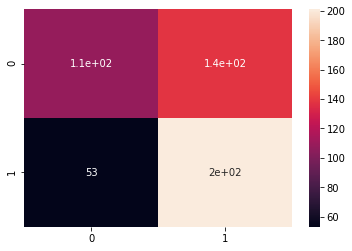

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib as plt

### Analysis Scripts
def analyze(y_true, y_pred):
    accuracy= accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    uniques = len(np.unique(y_true))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    tn, fp, fn, tp=confusion_matrix(y_true, y_pred).ravel()
    print('fn', fn)
    confusion_array=confusion_matrix(y_true, y_pred)
    confusion_array=confusion_array.astype('float')
    sns.heatmap(confusion_array, annot=True)
    #plt.xlabel('Predicted Class')
    #plt.ylabel('True Class')

    fnr = fn/(fn+tn)
    tpr = tp/(tp+fn)
    
    return [accuracy, precision, recall, auc, fnr, tpr]

results = analyze(Y_test, probs_cnn_opt.round())

print('Accuracy:', results[0]*100)
print('Precision:', results[1]*100)
print('Recall:', results[2]*100)
print('AUC: ', results[3]*100)
print('FNR:', results[4])
print('TPR:', results[5])

In [59]:

m = 0 # cancer
n = 0 # normal
for y in Y_test:
    if y == [1]:
        m += 1
    elif y == [0]:
        n += 1

print('Test Data:', '\n', 'Cancer:', m, '\n', 'Normal:', n, '\n', 'Ratio:', m/(m+n))

p = 0 # cancer
q = 0 # normal
for y in Y:
    if y == [1]:
        p += 1
    elif y == [0]:
        q += 1

print('Train Data:', '\n', 'Cancer:', p, '\n', 'Normal:', q, '\n', 'Ratio:', p/(p+q))

Test Data: 
 Cancer: 254 
 Normal: 246 
 Ratio: 0.508
Train Data: 
 Cancer: 1062 
 Normal: 938 
 Ratio: 0.531


In [60]:
cnn_gs = create_cnn(color=False, dense_units=16, bn=False, dr=0.3, 
               pool_fcn='average', opt_fcn='SGD', lr = 0.001, act_fcn='selu', 
               filters_t=[16, 96, 256], kernels=[6, 3], stride=3, pad_mthd='same')
cnn_gs.summary()
train_cnn_gs = cnn_gs.fit(X_gs, Y, epochs=10, validation_data=(X_gs_test, Y_test), verbose=2, callbacks=[es_cb_cnn, cp_cb_cnn])



Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 96, 96, 16)        592       
_________________________________________________________________
average_pooling2d_18 (Averag (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 48, 48, 96)        13920     
_________________________________________________________________
average_pooling2d_19 (Averag (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 24, 24, 256)       221440    
_________________________________________________________________
average_pooling2d_20 (Averag (None, 12, 12, 256)       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 36864)           

16/16 [==============================] - 1s 52ms/step - loss: 0.6527 - accuracy: 0.6280
fn 27
Accuracy: 62.8
Precision: 58.80829015544041
Recall: 89.37007874015748
AUC:  62.36796619934704
FNR: 0.23684210526315788
TPR: 0.8937007874015748


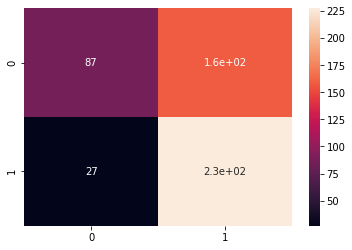

In [62]:
score_cnn_gs = cnn_gs.evaluate(X_gs_test, Y_test)
probs_cnn_gs = cnn_gs.predict(X_gs_test)
results_gs = analyze(Y_test, probs_cnn_gs.round())

print('Accuracy:', results_gs[0]*100)
print('Precision:', results_gs[1]*100)
print('Recall:', results_gs[2]*100)
print('AUC: ', results_gs[3]*100)
print('FNR:', results_gs[4])
print('TPR:', results_gs[5])